<a href="https://colab.research.google.com/github/hderoche/RNN_Bitcoin_Prediction/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing

In [612]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layer
from sklearn.preprocessing import MinMaxScaler

## Data Selection

In [613]:
path = '/content/drive/MyDrive/Colab Notebooks/Bitstamp_BTCUSD_d.csv'

data = pd.read_csv(path, header=0, sep=';')
data['diff'] = data['close'] - data['open']
data = data.drop(['unix', 'date', 'symbol', 'Volume USD'], axis=1)
data = data[::-1]
data['index'] = np.arange(data.shape[0])
data = data.reset_index(drop=True)
print(data.head())

     open    high     low   close  Volume BTC   diff  index
0  363.59  381.34  360.57  376.28  3220878.18  12.69      0
1  376.42  386.60  372.25  376.72  2746157.05   0.30      1
2  376.57  381.99  373.32  373.34  1145566.61  -3.23      2
3  376.40  382.31  373.03  378.39  2520662.37   1.99      3
4  378.39  382.86  375.23  379.25  2593576.46   0.86      4


Splitting the data into two parts

1.   Training data
2.   Testing data

The split_index is the percentage of the training data over the testing data


In [614]:
# In percentage
split_index = 70

index = int(np.floor(abs(data.shape[0] * split_index/100)))

data_train, data_test = data.loc[:index, :], data.loc[index + 1:, :]

print(data_train.shape)
print(data_test.shape)


(1555, 7)
(666, 7)


In [615]:
scaler = MinMaxScaler(feature_range=(0,1))
data_training, data_testing = scaler.fit_transform(data_train), scaler.fit_transform(data_test)
L_min = [np.min(data_test.iloc[:,0])]
L_min.append(np.min(data_test.iloc[:,1]))
L_min.append(np.min(data_test.iloc[:,2]))
L_min.append(np.min(data_test.iloc[:,3]))
L_min.append(np.min(data_test.iloc[:,4]))
L_min.append(np.min(data_test.iloc[:,5]))

## Getting the data for the train and test part
x_train = []
y_train = []

def data_selection(data_to_select):
    X = []
    y = []
    for i in range(data_to_select.shape[0] - 60):
        subset = []
        y.append(data_to_select[i + 60, :])
        for j in range(60):
            subset.append(data_to_select[i + j])
        X.append(subset)
    X,y = np.array(X),np.array(y)

    return X, y

x_test = []
y_test = []
x_train = []
y_train = []

for i in range(60, data_train.shape[0] - 1):
    x_train.append(data_training[i - 60:i])
    y_train.append(data_training[i + 1, :])

for i in range(60, data_test.shape[0] - 1):
    x_test.append(data_testing[i-60:i])
    y_test.append(data_testing[i + 1, :])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

print(x_test.shape)
print(x_train.shape)

(605, 60, 7)
(1494, 60, 7)


### Indicateurs

#### RSI

In [616]:
# RSI integration to the dataset
param = 14
def RSI(data, param): 
    dataLength = len(data)
    priceUp = []  
    priceDown = []
    k = 0
    while k < dataLength:
        if k == 0:
            priceUp.append(0)
            priceDown.append(0)
        else:
            diff = data['close'][k] - data['close'][k-1]
            if diff > 0:
                priceUp.append(diff)
                priceDown.append(0)
            elif diff <= 0:
                priceDown.append(diff)
                priceUp.append(0)
        k+=1
    avgGain = []
    avgLoss = []
    i = 0
    while i < dataLength:
        if i < param + 1:
            avgGain.append(0)
            avgLoss.append(0)
        else:
            avgGain.append(sum([priceUp[i-l] for l in range(0, param + 1)]) / param)
            avgLoss.append(np.abs(sum([priceDown[i-l] for l in range(0, param + 1)]) / param))
        i += 1
    RS = []
    RSI = []
    m = 0
    while m < dataLength:
        if avgGain[m] == 0 and avgLoss[m] == 0:
            RS_TempValue = 0
        else: 
            RS_TempValue = avgGain[m]/avgLoss[m]
        RS.append(RS_TempValue)
        RSI_TempValue = 100 - (100 / (1 + RS_TempValue))
        RSI.append(RSI_TempValue)
        m += 1
    data['RSI'] = RSI
    return data

data = RSI(data, param)

#### MA

In [617]:
def moving_average(data, param):
  data['MA' + str(param)] = data.iloc[:,3].rolling(window=param).mean().fillna(0)
  return data

data = moving_average(data, 200)

#### FMA (Fibonacci Moving Average)

In [618]:
def fibonacci(n):
  if n <= 1:
      return n
  else:
      return fibonacci(n-1) + fibonacci(n-2)

def FMA(n):
  fibo = []
  [fibo.append(fibonacci(i)) for i in range(3, n + 3)]
  print(fibo)
  temp_df = pd.DataFrame()
  temp_df['FMA'] = np.zeros(data.shape[0])
  for coeff in fibo:
    temp_df['FMA'] = temp_df['FMA'] + data.iloc[:, 3].ewm(span=param).mean()
  temp_df['FMA'] = temp_df['FMA']/len(fibo)
  print(temp_df)
  data['FMA'] = temp_df['FMA']
  return data

data = FMA(12)
print(data.tail())

[2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377]
               FMA
0       376.280000
1       376.515714
2       375.302581
3       376.247109
4       377.030559
...            ...
2216  21569.317141
2217  21793.102856
2218  22050.859808
2219  22404.765167
2220  22699.432478

[2221 rows x 1 columns]
          open      high       low  ...        RSI        MA200           FMA
2216  22750.07  23843.21  22383.59  ...  74.201168  12636.41455  21569.317141
2217  23819.08  24096.90  22624.92  ...  76.338762  12704.30385  21793.102856
2218  23215.00  23779.14  22700.10  ...  76.926274  12774.18505  22050.859808
2219  23747.22  24777.00  23403.82  ...  81.419177  12848.79580  22404.765167
2220  24714.01  24768.79  24532.28  ...  82.380753  12922.98545  22699.432478

[5 rows x 10 columns]


#### Visualisation

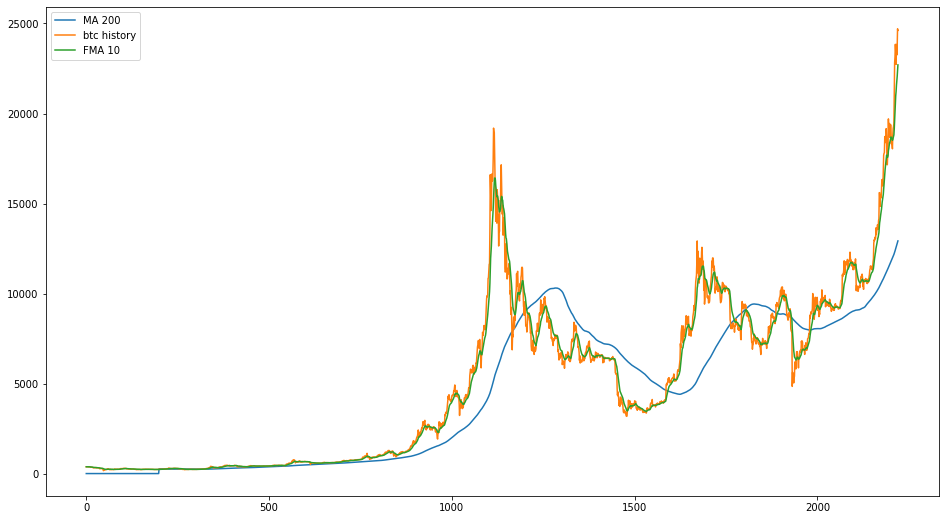

In [619]:
plt.figure(figsize=[16, 9])
plt.plot(data['MA200'], label='MA 200')
plt.plot(data['close'], label='btc history')
plt.plot(data['FMA'], label='FMA 10')
plt.legend()
plt.show()

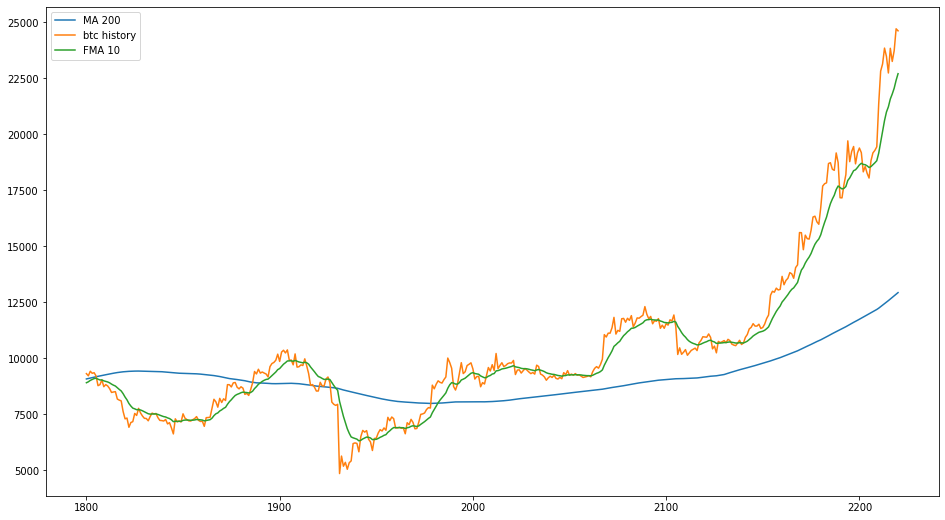

In [620]:
sm_data = data.copy()
sm_data = sm_data[1800:]

plt.figure(figsize=[16, 9])
plt.plot(sm_data['MA200'], label='MA 200')
plt.plot(sm_data['close'], label='btc history')
plt.plot(sm_data['FMA'], label='FMA 10')
plt.legend()
plt.show()

En regardant de plus près, on peut voir que la moyenne exponentielle Fibonnacci colle bien la courbe des prix et rebondit lorque le cours se rapproche de celle ci.

### Bot

Ici je créé le bot pour pouvoir récupérer les stats des trades, et permettre de simplifier le code.

Il sera alors possible d'instancier un nouveau bot pour une autre paire d'actif.

In [621]:
class Bot():
  def __init__(self):
    self.nb_trade = 0
    self.nb_long = 0
    self.nb_short = 0
    self.open_position = 0
    self.price_on_entry = -1
    self.time_on_entry = -1
    self.roe = []
    self.delta = []
    self.trade = []

  def entry(self):
    return self.price_on_entry
  
  def long(self, data):
    if self.on_position() == False:
      self.nb_trade += 1
      self.nb_long += 1
      self.open_position += 1
      self.price_on_entry = data['open']
      self.time_on_entry = data['index']
    else:
      return 'Already on position'

  def short(self, data):
    if self.on_position() == False:
      self.nb_trade += 1
      self.nb_short += 1
      self.open_position += 1
      self.price_on_entry = data['open']
      self.time_on_entry = data['index']
    else:
      return 'Already on position'
  
  def close_long(self, data):
    if self.on_position() == True :
      self.open_position -= 1
      diff = data['open'] - self.price_on_entry
      self.delta.append(diff)
      ROE = (diff/self.price_on_entry)*100
      self.roe.append(ROE)
      t = Trade(self.nb_trade, 'long', diff, ROE, self.price_on_entry, data['open'], self.time_on_entry, data['index'])
      self.trade.append(t)
    else:
      return 'Not on position'
  
  def close_short(self, data):
    if self.on_position() == True:
      self.open_position -= 1
      diff = self.price_on_entry - data['open']
      self.delta.append(diff)
      ROE = (diff/self.price_on_entry)*100
      self.roe.append(ROE)
      t = Trade(self.nb_trade, 'short',diff, ROE, self.price_on_entry, data['open'], self.time_on_entry, data['index'])
      self.trade.append(t)
    else:
      return 'Not on position'
  
  def on_position(self):
    if self.open_position != 0:
      return True
    else:
      return False

  def add_trade(self, i):
    t = Trade(i, 100, 10)
    self.trade.append(t)

  def on_profit(self):
    if len(self.roe) > 0 and self.nb_trade > 0:
      mean_roe = sum(self.roe) / len(self.roe)
      if mean_roe > 0:
        return True, mean_roe
      else:
          return False, mean_roe
    else:
      print('No trade yet')
      return
  
  def show_trades(self):
    df_trade = pd.DataFrame.from_records([trade.to_dict() for trade in self.trade])
    return df_trade

class Trade():
  def __init__(self, nb_trade, trade, delta, roe, entry_price, closing_price, date_entry, date_close):
    self.nb_trade = nb_trade
    self.trade = trade
    self.delta = delta
    self.roe = roe
    self.entry_price = entry_price
    self.closing_price = closing_price
    self.date_entry = date_entry  
    self.date_close = date_close  
  def to_string(self):
    print('Trade #' + str(self.nb_trade) + ' - Delta : ' + str(self.delta) + ' - PNL : ' + str(self.roe))
  
  def to_dict(self):
    return {
        '#': self.nb_trade,
        'trade': self.trade,
        'Delta': self.delta,
        'PNL': self.roe,
        'Entry': self.entry_price,
        'Close': self.closing_price, 
        'Entry date': self.date_entry,
        'Close date': self.date_close
    }

## Defining the scoring system


Le bot de trading déterminera les ordres d'achat ou de vente si les conditions suivantes sont validées. La méthode de scoring permet de mettre une stratégie en place dès qu'un nombre définit de condition sont réunis

*   MA200 (donne la tendance générale du mouvement)
  *   Au dessus du cours -> Achat +1
  *   En dessous -> Vente -1
*   RSI
  *   Si en survente -> Achat +1
  *   En surachat -> Vente -1
*   Prédiction AI model
  * Si 1 -> +2
  * Si 0 -> -2
*   FMA - Si data[open] - FMA < epsilon
    * Si positif -> Achat +1
    * Si négatif -> Vente -1

In [622]:
# Initialisation du Bot
btcBot = Bot()

In [646]:
# Data à instant t
def rules(data):
  score = 0
  if data['open'] > data['MA200'] :
    score += 2
  if data['open'] < data['MA200']:
    score -= 2
  if data['RSI'] > 70:
    score -= 1
  if data['RSI'] < 65:
    score += 1
  # if data['pred'] == 1:
  #   score += 2
  # if data['pred'] == 0:
  #   score -= 2
  return score

# Score to trigger an order
threshold = 3
# Target and risk (in %) if reached, then close position
target = 7.5
risk = 5

def decision(score, data):
  position = 0
  for i in range(data.shape[0]):
    _score = score[i]
    _data = data.iloc[i, :]
    onPos = btcBot.on_position()
    if onPos == False :
      if _score >= threshold:
        btcBot.long(_data)
        position = 1
      if _score <= - threshold:
        btcBot.short(_data)
        position = -1
    elif onPos == True:
      delta = _data['open'] - btcBot.entry()
      pnl = (delta / btcBot.entry())*100
      # si le trade est perdant -> cloturer la position
      if pnl < - risk and position == 1 or pnl > target:
        btcBot.close_long(_data)
      elif pnl > risk and position == -1 or pnl < -target:
        btcBot.close_short(_data)
      # si le trade est gagnant -> on laisse courir
      # plus tard eventuellement ajouter les take-profit partiels pour assurer le BE ou un minimum de gain



### BackTesting

In [647]:
def backtest():
  L_score = []
  for i in range(data.shape[0]):
    L_score.append(rules(data.iloc[i, :]))
  decision(L_score, data)

backtest()

In [648]:
print(btcBot.on_profit())
df_trade = btcBot.show_trades()
print(df_trade)
print('mean PNL per trade :', df_trade['PNL'].mean())
print('number of long open :', btcBot.nb_long)
print('number of short open :', btcBot.nb_short)

(True, 0.18103689115424845)
       #  trade    Delta        PNL     Entry     Close  Entry date  Close date
0      1   long   -32.03  -8.809373    363.59    331.56         0.0        19.0
1      2   long   -35.31 -10.989045    321.32    286.01        20.0        37.0
2      3   long   -47.16 -17.586516    268.16    221.00        46.0        47.0
3      4  short   -12.83  -5.438284    235.92    248.75       200.0       201.0
4      5   long   -17.30  -6.200495    279.01    261.71       253.0       254.0
..   ...    ...      ...        ...       ...       ...         ...         ...
593  594   long -1736.37 -14.595797  11896.37  10160.00      2083.0      2107.0
594  595   long   840.77   8.037800  10460.20  11300.97      2108.0      2144.0
595  596   long -1558.93  -8.324398  18727.24  17168.31      2190.0      2191.0
596  597   long  2543.15  14.819893  17160.38  19703.53      2192.0      2195.0
597  598   long  2585.75  13.773617  18773.21  21358.96      2196.0      2211.0

[598 rows x

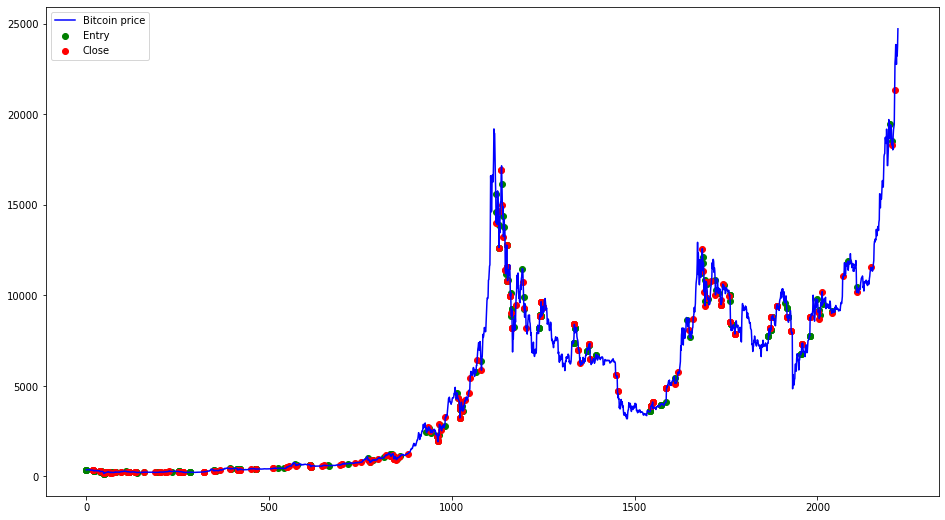

In [642]:
plt.figure(figsize=[16, 9])
plt.scatter(df_trade['Entry date'], df_trade['Entry'], color='green', label='Entry')
plt.scatter(df_trade['Close date'], df_trade['Close'], color='red', label='Close')
plt.plot(data['open'], color='blue', label='Bitcoin price')
plt.legend()
plt.show()

## AI Model

In [627]:
def AI_model():
    model = tf.keras.Sequential()

    model.add(layer.LSTM(units = 600, activation=tf.nn.relu, return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2])))
    model.add(layer.Dropout(0.4))
    model.add(layer.LSTM(units = 600, activation=tf.nn.relu, return_sequences=True))
    model.add(layer.Dropout(0.2))
    model.add(layer.LSTM(units=600, activation=tf.nn.relu))
    model.add(layer.Dropout(0.2))
    model.add(layer.Dense(60))
    model.add(layer.Dense(6))


    # As this is a regression model, we want to calulate the price of the asset for the next day, we use the mean sqaured error as a loss funtion.
    # The adam optimizer is the standard in the AI libraries.
    model.compile(optimizer='adam',
                  loss = 'mean_squared_error')

     # Show how the RNN is structured and how many parameters there is.
    print(model.summary())

    # Fitting the model to the train dataset
    # Changing the epoch number will decrease the render time

    model.fit(x_train, y_train, epochs=10, batch_size=32)


    # Saving the model
    model.save('/content/drive/MyDrive/Colab Notebooks/btcAI')

In [628]:
#AI_model()

In [629]:
# Loading the model from the file in the same repository
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/btcAI')
#print(X_test[:6])
# Getting the results on the test dataset
y_preds = new_model.predict(x_test, use_multiprocessing=True)

#first_y = new_model.predict(X_test)
#print(first_y)


# Unscaling the data, in order to have the real results
# This step can be a source of error because we might loose some information by unscaling the data and deforming it
for i in range(y_test.shape[1]):
  scale = scaler.scale_[i]
  y_test[:, i] = y_test[:, i]/scale + L_min[i]
  y_preds[:, i] = y_preds[:, i]/scale + L_min[i]

# Printing the latest value for the predicted value and the real value
print("Last real value : ", y_test[-1])
print("Last predicted value : ",y_preds[-1])
print(data.columns)

ValueError: ignored

In [ ]:
plt.figure(figsize=[16, 9])
plt.plot(y_test[:,3])
plt.plot(y_preds[:, 3])
plt.show()

In [ ]:
## Difference

print(len(y_preds))
print(len(y_test))
diff_test = []
diff_test_preds = []
for i in range(1,len(y_test)):
  temp_diff = y_test[i, 3] - y_test[i-1, 3]
  temp_diff_preds = y_preds[i, 3] - y_preds[i-1, 3]
  if temp_diff >= 0:
    diff_test.append(1)
    diff_test_preds.append(1)
  elif temp_diff < 0:
    diff_test.append(0)
    diff_test_preds.append(0)

score = 0
for i in range(len(diff_test)):
  if diff_test[i] == diff_test_preds[i]:
    score += 1
if score == len(diff_test):
  print('all good')
print(score)
    

In [ ]:

# for i in range(60, data_test.shape[0] - 1):
#     x_test.append(data_testing[i-60:i])

def prediction():
  
  all_pred = x_test.copy()
  all_pred = all_pred[:100]
  all_data_test = data_testing.copy()
  all_data_test = all_data_test[:100]


  for i in range(all_pred.shape[0]-1):
    for j in range(60, all_data_test.shape[0]):
      all_pred[] = all_data_test[j-60:j]
      all_pred[i+1] = all_data_test[j + 1 -60:j+1]
    next_pred = new_model.predict(all_pred[i:i+1, :])
    #print(i, next_pred[0])
    if i + 2 >= all_pred.shape[0]: 
      np.append(all_data_test, next_pred[0])
    else:
      all_data_test[i+2, :] = next_pred[0]
  return all_data_test


#predictions = prediction()
#print(predictions.shape)

In [ ]:
for i in range(predictions.shape[2]):

  scale = scaler.scale_[i]
  predictions[:, i] = predictions[:, i]/scale + L_min[i]

print(predictions)
print(x_test.shape)

In [ ]:
print(predictions.shape)
print(y_test.shape)
plt.figure(figsize=[16, 9])
plt.plot(y_test[:, 3])
plt.plot(predictions[:, 3])
plt.show()